# Development of several src functions

## make_roms_ds

In [70]:
%%writefile ../../src/features/roms_ds.py
#read in raw data as xr.dataset
import xarray as xr
import numpy as np
from .calc_z import calc_z
from .cartesian_grid_3d import cartesian_grid_3d
from .rotate_vector_roms import rotate_vector_roms

def make_4D_mask(ds):

    
    mask_4d = np.tile(ds.mask_rho,(ds.ocean_time.size,ds.s_rho.size,1,1))
    ds['mask_4d'] = xr.DataArray(mask_4d,dims=['ocean_time','s_rho','eta_rho','xi_rho'])
    ds.mask_4d.attrs = ds.mask_rho.attrs
    
    return ds



def make_3D_XiEta(ds):
    
    xi_3d = np.tile(ds.xi_rho,(ds.s_rho.size,ds.eta_rho.size,1))
    eta_3d = np.swapaxes(np.tile(ds.eta_rho,(ds.s_rho.size,ds.xi_rho.size,1)),1,2)
    
    xi_3d_da = xr.DataArray(xi_3d,dims=['s_rho','eta_rho','xi_rho'])
    eta_3d_da = xr.DataArray(eta_3d,dims=['s_rho','eta_rho','xi_rho'])
    
    ds = ds.assign_coords(xi_3d=xi_3d_da)
    ds = ds.assign_coords(eta_3d=eta_3d_da)
    
    ds['xi_3d'] = ds.xi_3d.where(ds.mask_rho == 1)
    ds['eta_3d'] = ds.eta_3d.where(ds.mask_rho ==1)
    
    ds.xi_3d.attrs = ds.xi_rho.attrs
    ds.eta_3d.attrs = ds.eta_rho.attrs
    
    return ds



def make_4D_depth(ds):
    
    depths = np.empty((ds.ocean_time.size,ds.s_rho.size,ds.eta_rho.size,ds.xi_rho.size))
    
    for tstep in np.arange(ds.ocean_time.size):

        h = ds.h.values
        zice = ds.zice.values
        theta_s = ds.theta_s.values
        theta_b = ds.theta_b.values
        hc = ds.hc.values
        N = ds.s_rho.size
        zeta = ds.zeta[tstep].values
        Vstretching = ds.Vstretching.values
        
        depths[tstep],s,C = calc_z(h,zice,theta_s,theta_b,hc,N,zeta,Vstretching)
        
    ds = ds.assign_coords(depth = xr.DataArray(depths,dims=['ocean_time','s_rho','eta_rho','xi_rho']))
    
    ds['depth'] = ds.depth.where(ds.mask_rho == 1)
    
    return ds

def make_cartesian_grid_3D(ds):
    
    lon_u = ds.lon_u.values
    lat_u = ds.lat_u.values
    lon_v = ds.lon_v.values
    lat_v = ds.lat_v.values
    h = ds.h.values
    zice = ds.zice.values
    theta_s = ds.theta_s.values
    theta_b = ds.theta_b.values
    hc = ds.hc.values
    N = ds.s_rho.size
    
    z = np.empty((ds.ocean_time.size,ds.s_rho.size,ds.eta_rho.size,ds.xi_rho.size))
    dz = np.empty(np.shape(z))
    
    for tstep in np.arange(ds.ocean_time.size):
        
        zeta = ds.zeta[tstep].values
        
        dx,dy,dz[tstep],z[tstep] = cartesian_grid_3d(lon_u, lat_u, lon_v, lat_v, h, zice, theta_s, theta_b, hc, N, zeta)
        
    ds['dx'] = xr.DataArray(dx,dims=['s_rho','eta_rho','xi_rho'])
    ds['dx'] = ds.dx.where(ds.mask_rho == 1)
    
    ds['dy'] = xr.DataArray(dy,dims=['s_rho','eta_rho','xi_rho'])
    ds['dy'] = ds.dy.where(ds.mask_rho == 1)
    
    ds['dz'] = xr.DataArray(dz,dims=['ocean_time','s_rho','eta_rho','xi_rho'])
    ds['dz'] = ds.dz.where(ds.mask_rho == 1)
    
    ds['z'] = xr.DataArray(z,dims=['ocean_time','s_rho','eta_rho','xi_rho'])
    ds['z'] = ds.z.where(ds.mask_rho == 1)
    
    dV = ds.dx * ds.dy * ds.dz
    ds['dV'] = dV
    
    return ds

def make_uvbar_lonlat(ds):
    
    angle = ds.angle.values
    
    ubar_lonlat = np.empty((ds.ocean_time.size,ds.eta_rho.size,ds.xi_rho.size))
    vbar_lonlat = np.empty((ds.ocean_time.size,ds.eta_rho.size,ds.xi_rho.size))
    
    for tstep in np.arange(ds.ocean_time.size):
        ubar=ds.ubar[tstep].values
        vbar=ds.vbar[tstep].values
        
        ubar_lonlat[tstep],vbar_lonlat[tstep] = rotate_vector_roms(ubar,vbar,angle)
        
    ds['ubar_lonlat'] = xr.DataArray(ubar_lonlat,dims=['ocean_time','eta_rho','xi_rho'])
    ds['ubar_lonlat'] = ds.ubar_lonlat.where(ds.mask_rho == 1) 
    ds.ubar_lonlat.attrs = ds.u_bar.attrs
    
    ds['vbar_lonlat'] = xr.DataArray(vbar_lonlat,dims=['ocean_time','eta_rho','xi_rho'])
    ds['vbar_lonlat'] = ds.vbar_lonlat.where(ds.mask_rho == 1)
    ds.vbar_lonlat.attrs = ds.vbar.attrs
    
    return ds

def make_uv_lonlat(ds):
    
    angle = ds.angle.values
    
    u_lonlat = np.empty((ds.ocean_time.size,ds.s_rho.size,ds.eta_rho.size,ds.xi_rho.size))
    v_lonlat = np.empty((ds.ocean_time.size,ds.s_rho.size,ds.eta_rho.size,ds.xi_rho.size))
    
    for tstep in np.arange(ds.ocean_time.size):
        for level in np.arange(ds.s_rho.size):
            u=ds.u[tstep,level].values
            v=ds.v[tstep,level].values
        
            u_lonlat[tstep,level],v_lonlat[tstep,level] = rotate_vector_roms(u,v,angle)
        
    ds['u_lonlat'] = xr.DataArray(u_lonlat,dims=['ocean_time','s_rho','eta_rho','xi_rho'])
    ds['u_lonlat'] = ds.u_lonlat.where(ds.mask_rho == 1) 
    ds.u_lonlat.attrs = ds.u.attrs
    
    ds['v_lonlat'] = xr.DataArray(v_lonlat,dims=['ocean_time','s_rho','eta_rho','xi_rho'])
    ds['v_lonlat'] = ds.v_lonlat.where(ds.mask_rho == 1)
    ds.v_lonlat.attrs = ds.v.attrs
    
    return ds
    

def make_roms_ds(file_paths):
    '''Takes a roms history or averages file (wildcards are possible) and returns a Xarray dataset including 4D mask, 3D grid coordinates and 4D depths'''
    
    print('set up multifile dataset')
    ds_tmp = xr.open_mfdataset(file_paths,data_vars='minimal')
    
    print('set up 4D mask and add as variable to dataset')
    ds_tmp = make_4D_mask(ds_tmp)
    
    print('set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates')
    ds_tmp = make_3D_XiEta(ds_tmp)
    
    print('calculate 4D depth array, fill with NaNs where invalid and apply as coordinate')
    ds = make_4D_depth(ds_tmp)
    
    return ds

Overwriting ../../src/features/roms_ds.py


### Test roms_ds functions

In [74]:
import os
import sys
import xarray as xr

# add the 'src/' directory as one where we can import modules
src_dir = os.path.join(os.pardir,'src')
sys.path.append(src_dir)

from features.roms_ds import make_roms_ds
    
file_path = os.path.join(os.pardir,'data','raw','waom10_full_forcing','ocean_avg_000[4,5].nc')
#ds = make_roms_ds(file_path)
#ds = xr.open_mfdataset(file_path,data_vars='minimal')

In [78]:
ds = make_roms_ds(file_path)

set up multifile dataset
set up 4D mask and add as variable to dataset
set up 3D xi and eta arrays, mask them and apply as coordinates
calculate 4D depth array


In [86]:

#ds = ds.assign_coords(latlon = xr.DataArray(latlon,dims=['eta_rho','xi_rho']))

KeyboardInterrupt: 

In [36]:
depths = np.empty((ds.ocean_time.size,ds.s_rho.size,ds.eta_rho.size,ds.xi_rho.size))

N = ds.s_rho.size

if 'ocean_time' in ds.h.dims:    
    
    h = ds.h[0].values
    zice = ds.zice[0].values
    theta_s = ds.theta_s[0].values
    theta_b = ds.theta_b[tstep].values
    hc = ds.hc[tstep].values
for tstep in np.arange(ds.ocean_time.size):

    h = ds.h[tstep].values
    zice = ds.zice[tstep].values
    theta_s = ds.theta_s[tstep].values
    theta_b = ds.theta_b[tstep].values
    hc = ds.hc[tstep].values
    N = ds.s_rho.size
    zeta = ds.zeta[tstep].values
    Vstretching = ds.Vstretching[tstep].values
    depths[tstep],s,C = calc_z(h,zice,theta_s,theta_b,hc,N,zeta,Vstretching)

depth_da = xr.DataArray(depths,dims=['ocean_time','s_rho','eta_rho','xi_rho'])
ds = ds.assign_coords(depth=depth_da)

(12, 31, 730, 860)

In [41]:
ds

0.03225806451612903

In [49]:
N=31
alpha = 1.0
beta = 1.0
ds = 1.0/N
lev = np.arange(1,N+1)-0.5
s = (lev-N)*ds

theta_s = roms_ds.theta_s
theta_b = roms_ds.theta_b
print(theta_s.shape,np.shape(s))
C = (1-np.cosh(theta_s*s))/(np.cosh(theta_s)-1)
C = (exp(theta_b*C)-1)/(1-exp(-theta_b))


TypeError: expand_dims() got an unexpected keyword argument 'dims'

### Build a test fpr pytest

In [22]:
%%writefile ../src/features/test_features.py

import os
import sys

# add the 'src/' directory as one where we can import modules
src_dir = os.path.join('src')
sys.path.append(src_dir)

def test_make_roms_ds():
    
    from features.roms_ds import make_roms_ds
    import os
    
    file_path = os.path.join(os.pardir,'data','raw','waom10_full_forcing','ocean_avg_000[4,5].nc')
    ds = make_roms_ds(file_path)
    
    assert ds.depth.isnull().any() == True, 'depth has no NaN'

Overwriting ../src/features/test_features.py


In [15]:
test_make_roms_ds()

set up multifile dataset
set up 4D mask and add as variable to dataset
set up 3D xi and eta arrays, mask them and apply as coordinates
calculate 4D depth array
apply mask to depths
assign depth as new coordinate to the data set


catch exception that mask is not time dependent in avg file

### Transect Plotting example

In [69]:
import sys
import os

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

# add the 'src/visualization/' directory as one where we can import modules
src_dir = os.path.join(os.pardir,'src')
sys.path.append(src_dir)

# import my methods, make sure they get reloded by each call
%aimport features.roms_ds

from features.roms_ds import make_roms_ds

file_path = os.path.join(os.pardir,'data','raw','waom10_full_forcing','ocean_avg_0005.nc')

rds = make_roms_ds(file_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
set up multifile dataset
set up 4D mask and add as variable to dataset
set up 3D xi and eta arrays, fill with NaNs where invalid and apply as coordinates
calculate 4D depth array, fill with NaNs where invalid and apply as coordinate


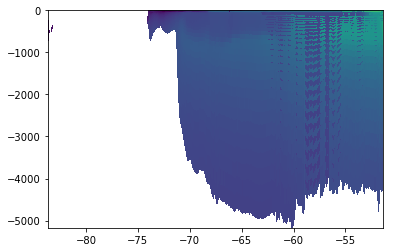

In [70]:
plt.clf()
da = rds.temp[0,:,300]
val = da.to_masked_array()
x = da.lat_rho.to_masked_array()
y = da.depth.to_masked_array()
plt.pcolormesh(x,y,val)
plt.colorbar()
plt.xlable('')
plt.show()

## make_sose_ds

In [72]:
%%writefile ../../src/features/sose_ds.py
import os
import sys
import xarray as xr
import pandas as pd
import scipy.io as sio
import numpy as np
import features.mds as mds


def make_TS_ds(sose_dir=os.path.join(os.environ.get('extdir'),'sose'),records=None):
    '''Reads in SothernOceanStateEstimate Temperatures and Salinities and returns them in a Xarray dataset.'''
    
    #load grid data
    print("load grid")
    grid_path = os.path.join(sose_dir,'grid.mat')
    grid_raw = sio.loadmat(grid_path)
    
    longitude = grid_raw["XC"][:,0]
    latitude = grid_raw['YC'][0,:]
    depth = grid_raw['RC'].squeeze()
    DRC = grid_raw['DRC'].squeeze()
    maskC = np.flipud(np.rot90(grid_raw['maskCtrlC']))
    DXC = np.flipud(np.rot90(grid_raw['DXC']))
    DYC = np.flipud(np.rot90(grid_raw['DYC']))
    Depth = np.flipud(np.rot90(grid_raw['Depth']))
    
    #load temperature data
    print("load temperature")
    temp_path = os.path.join(sose_dir,'THETA_mnthlyBar')
    temp_raw = mds.rdmds(temp_path,100,rec=records,fill_value=np.NaN)
    
    #load salt data
    print("load salt")
    salt_path = os.path.join(sose_dir,'SALT_mnthlyBar')
    salt_raw = mds.rdmds(salt_path,100,rec=records,fill_value=np.NaN)
    
    #define array of datetime range
    time = pd.period_range('2005-01',periods=len(temp_raw),freq='M')
    time_stamp = pd.Timestamp('2005-01')
    
    #construct Xarray dataset
    print("construct Xarray dataset")
    ds = xr.Dataset({'temperature':(['time','depth','latitude','longitude'],temp_raw),
                 'salinity':(['time','depth','latitude','longitude'],salt_raw),
                 'maskC':(['latitude','longitude','depth'],maskC),
                 'DRC':(['depth'],DRC),
                 'DXC':(['latitude','longitude'],DXC),
                 'DYC':(['latitude','longitude'],DYC),
                 'Depth':(['latitude','longitude'],Depth)},
                coords={'longitude':(('longitude'),longitude),
                       'latitude':(('latitude'),latitude),
                       'depth':(('depth'),depth),
                       'time':(('time'),time),
                       'reference_time':time_stamp})
    
    print("done!")
    
    return ds


Overwriting ../../src/features/sose_ds.py


### test

In [64]:
#test
import sys
import os

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

# add the 'src/visualization/' directory as one where we can import modules
src_dir = os.path.join(os.pardir,'src')
sys.path.append(src_dir)

# import my methods, make sure they get reloded by each call
%aimport features.sose_ds

from features.sose_ds import make_TS_ds

ds = make_TS_ds(records=[0,1])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
load grid
load temperature


/home/ubuntu/bigStick/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


load salt
construct Xarray dataset
done!


In [65]:
ds

<xarray.Dataset>
Dimensions:         (depth: 42, latitude: 320, longitude: 2160, time: 2)
Coordinates:
  * longitude       (longitude) float32 0.0833333 0.25 0.416667 0.583333 ...
  * latitude        (latitude) float32 -77.875 -77.7083 -77.5416 -77.375 ...
  * depth           (depth) float32 -5.0 -15.5 -27.0 -39.5 -53.0 -68.0 -85.0 ...
  * time            (time) object 2005-01 2005-02
    reference_time  datetime64[ns] 2005-01-01
Data variables:
    temperature     (time, depth, latitude, longitude) float64 0.0 0.0 0.0 ...
    salinity        (time, depth, latitude, longitude) float64 0.0 0.0 0.0 ...
    maskC           (latitude, longitude, depth) float32 0.0 0.0 0.0 0.0 0.0 ...
    DRC             (depth) float32 5.0 10.5 11.5 12.5 13.5 15.0 17.0 19.0 ...
    DXC             (latitude, longitude) float32 3892.06 3892.06 3892.06 ...
    DYC             (latitude, longitude) float32 18529.6 18529.6 18529.6 ...
    Depth           (latitude, longitude) float32 0.0 0.0 0.0 0.0 0.0 0.0 ..